In [1]:
import numpy as np
import matplotlib.pyplot as plt
import solver as mysolver             # your own solver
import solution.solver_sol as solver  # compare your results with solution
from scipy.integrate import solve_ivp as solver_scipy

In [18]:
# RLC circuit

# define y' function
def f(t, y0, L = 1, C = 1, R = 0.8, E_0 = 1, omega_f = 0.7): # gamma = lambda / 2m = 0.005
    emf = -R * y0[1] - 1 / C * y0[0] + E_0 * np.cos(omega_f * t)
    a = emf / L
    a_dot = -R * a - 1 / C * y0[1] - E_0 * omega_f * np.sin(omega_f * t)
    return np.array([y0[1], a, a_dot])

# Prepare the input arguments
t_span = [0, 50]
t_eval = np.linspace(0, 50, 50001, endpoint=True)
C = 1
L = 1
omega_0 = 1 / np.sqrt(L * C)
R = 0.8
E_0 = 1
gamma = R / (2 * L)
omega = np.sqrt(omega_0 ** 2 - gamma ** 2)
omega_f = 0.7

A = 1
phi = -np.pi / 2

try:
    delta = np.arctan(2 * gamma * omega_f / (omega_0 ** 2 - omega_f ** 2))
except ZeroDivisionError:
    delta = np.pi / 2

# D is the constant in front of the cosine term in the analytical solution
D = E_0 / (np.sqrt((omega_0 ** 2 - omega_f ** 2) ** 2 + 4 * gamma ** 2 * omega_f ** 2)) 

# calculate initial conditions
q0 = A * np.exp(-gamma * t_eval[0]) * np.cos(omega * t_eval[0] + phi) \
        + D * np.cos(omega_f * t_eval[0] - delta)

q_dot0 = - A * np.exp(-gamma * t_eval[0]) \
        * (gamma * np.cos(omega * t_eval[0] + phi) + omega * np.sin(omega * t_eval[0] + phi)) \
        - D * omega_f * np.sin(omega_f * t_eval[0] - delta)

q_dot_dot0 = -gamma * q_dot0 - A * np.exp(-gamma * t_eval[0]) * (omega ** 2 * np.cos(omega * t_eval[0] + phi) \
            - gamma * omega * np.sin(omega * t_eval[0] + phi)) \
            - D * omega_f ** 2 * np.cos(omega_f * t_eval[0] - delta)


args = (L, C, R, E_0, omega_f)
y0 = np.array([q0, q_dot0, q_dot_dot0])

# use the IVP solver
sol_rk4 = mysolver.solve_ivp(f, t_span, y0, method='RK4', t_eval=t_eval, args=args)

####################################################################################################

# analytical solution
q = np.zeros(len(t_eval))
q_dot = np.zeros(len(t_eval))
q_dot_dot = np.zeros(len(t_eval))

q[0] = q0
q_dot[0] = q_dot0
q_dot_dot[0] = - R * q_dot[0] - 1 / L * q[0] + E_0 * np.cos(omega_f * t_eval[0])

sol_analytical = np.zeros((3, len(t_eval)))
sol_analytical[0, 0] = y0[0]
sol_analytical[1, 0] = y0[1]
sol_analytical[2, 0] = y0[2]

for i in range(1, len(t_eval)):
    q[i] = A * np.exp(-gamma * t_eval[i]) * np.cos(omega * t_eval[i] + phi) \
        + D * np.cos(omega_f * t_eval[i] - delta)
    
    q_dot[i] = - A * np.exp(-gamma * t_eval[i]) \
        * (gamma * np.cos(omega * t_eval[i] + phi) + omega * np.sin(omega * t_eval[i] + phi)) \
        - D * omega_f * np.sin(omega_f * t_eval[i] - delta)
    
    q_dot_dot[i] = -gamma * q_dot[i] - A * np.exp(-gamma * t_eval[i]) \
            * (omega ** 2 * np.cos(omega * t_eval[i] + phi) \
            - gamma * omega * np.sin(omega * t_eval[i] + phi)) \
            - D * omega_f ** 2 * np.cos(omega_f * t_eval[i] - delta)
    
    sol_analytical[0, i] = q[i]
    sol_analytical[1, i] = q_dot[i]
    sol_analytical[2, i] = q_dot_dot[i]


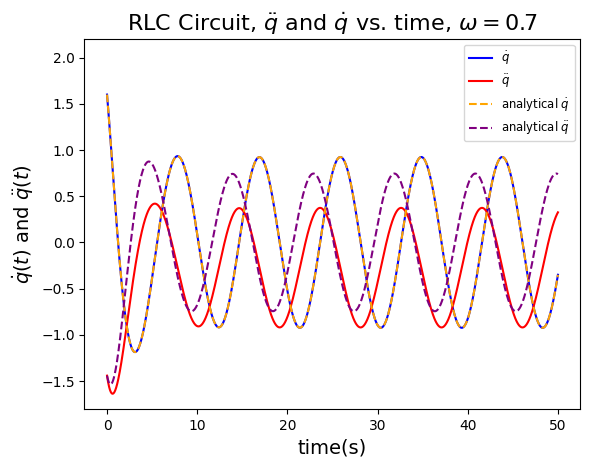

In [28]:
# plot the results

# plt.plot(t_eval, sol_rk4[0], label='q', color='green')
plt.plot(t_eval, sol_rk4[1], label='$\\dot{q}$', color='blue')
plt.plot(t_eval, sol_rk4[2], label='$\\ddot{q}$', color='red')
# plt.plot(t_eval, sol_analytical[0], label='analytical q', color='yellow', linestyle='--')
plt.plot(t_eval, sol_analytical[1], label='analytical $\\dot{q}$', color='orange', linestyle='--')
plt.plot(t_eval, sol_analytical[2], label='analytical $\\ddot{q}$', color='purple', linestyle='--')

# add vertical line at t = 8
# plt.axvline(x=8, color='black', linestyle='--')

plt.xlabel('time(s)', fontsize=14)
plt.ylabel('$\dot{q}(t)$ and $\\ddot{q}(t)$', fontsize=14) 
plt.ylim([-1.8, 2.2])
# adjust the legend size and location
plt.legend(fontsize='small', loc='upper right')
plt.title('RLC Circuit, $\\ddot{q}$ and $\\dot{q}$ vs. time, $\\omega = %.1f$' % (omega_f), fontsize=16)
# plt.savefig('RLC_circuit.png')
plt.show()

In [14]:

slope = (sol_rk4[1][8001] - sol_rk4[1][8000]) / (t_eval[8001] - t_eval[8000])
print(f'The slope at t = 8 is {slope}')
print('rk4: ', sol_rk4[2][8000])
print('analytical: ', sol_analytical[2][8000])

The slope of q dot at t = 8 is -0.07550492308865141
rk4:  -0.34860551508042126
analytical:  -0.44392650894038554


In [9]:
# change omega

omega_f_arr = np.arange(0.3, 1.51, 0.1)
amp_arr = np.array([])

for x in omega_f_arr:
    # define y' function
    def f(t, y0, L = 1, C = 1, R = 0.8, E_0 = 1, omega_f = x): # gamma = lambda / 2m = 0.005
        emf = -R * y0[1] - 1 / C * y0[0] + E_0 * np.cos(omega_f * t)
        a = emf / L
        # a_dot = -R * a - 1 / C * y0[1] - E_0 * omega_f * np.sin(omega_f * t)
        return np.array([y0[1], a])

    # Prepare the input arguments
    t_span = [0, 50]
    t_eval = np.linspace(0, 50, 50001, endpoint=True)
    C = 1
    L = 1
    omega_0 = 1 / np.sqrt(L * C)
    R = 0.8
    E_0 = 1
    gamma = R / (2 * L)
    omega = np.sqrt(omega_0 ** 2 - gamma ** 2)
    omega_f = x

    A = 1
    phi = -np.pi / 2

    try:
        delta = np.arctan(2 * gamma * omega_f / (omega_0 ** 2 - omega_f ** 2))
    except ZeroDivisionError:
        delta = np.pi / 2

    # D is the constant in front of the cosine term in the analytical solution
    D = E_0 / (np.sqrt((omega_0 ** 2 - omega_f ** 2) ** 2 + 4 * gamma ** 2 * omega_f ** 2)) 

    # calculate initial conditions
    q0 = A * np.exp(-gamma * t_eval[0]) * np.cos(omega * t_eval[0] + phi) \
            + D * np.cos(omega_f * t_eval[0] - delta)

    q_dot0 = - A * np.exp(-gamma * t_eval[0]) \
            * (gamma * np.cos(omega * t_eval[0] + phi) + omega * np.sin(omega * t_eval[0] + phi)) \
            - D * omega_f * np.sin(omega_f * t_eval[0] - delta)

    # q_dot_dot0 = -gamma * q_dot0 - A * np.exp(-gamma * t_eval[0]) * (omega ** 2 * np.cos(omega * t_eval[0] + phi) \
    #             - gamma * omega * np.sin(omega * t_eval[0] + phi)) \
    #             - D * omega_f ** 2 * np.cos(omega_f * t_eval[0] - delta)


    args = (L, C, R, E_0, omega_f)
    y0 = np.array([q0, q_dot0])

    # use the IVP solver
    sol_rk4 = mysolver.solve_ivp(f, t_span, y0, method='RK4', t_eval=t_eval, args=args)

    ####################################################################################################

    # analytical solution
    q = np.zeros(len(t_eval))
    q_dot = np.zeros(len(t_eval))
    # q_dot_dot = np.zeros(len(t_eval))

    q[0] = q0
    q_dot[0] = q_dot0
    # q_dot_dot[0] = - R * q_dot[0] - 1 / L * q[0] + E_0 * np.cos(omega_f * t_eval[0])

    sol_analytical = np.zeros((2, len(t_eval)))
    sol_analytical[0, 0] = y0[0]
    sol_analytical[1, 0] = y0[1]
    # sol_analytical[2, 0] = y0[2]

    for i in range(1, len(t_eval)):
        q[i] = A * np.exp(-gamma * t_eval[i]) * np.cos(omega * t_eval[i] + phi) \
            + D * np.cos(omega_f * t_eval[i] - delta)
        
        q_dot[i] = - A * np.exp(-gamma * t_eval[i]) \
            * (gamma * np.cos(omega * t_eval[i] + phi) + omega * np.sin(omega * t_eval[i] + phi)) \
            - D * omega_f * np.sin(omega_f * t_eval[i] - delta)
        
        # q_dot_dot[i] = -gamma * q_dot[i] - A * np.exp(-gamma * t_eval[i]) \
        #         * (omega ** 2 * np.cos(omega * t_eval[i] + phi) \
        #         - gamma * omega * np.sin(omega * t_eval[i] + phi)) \
        #         - D * omega_f ** 2 * np.cos(omega_f * t_eval[i] - delta)
        
        sol_analytical[0, i] = q[i]
        sol_analytical[1, i] = q_dot[i]
        # sol_analytical[2, i] = q_dot_dot[i]

    amp = 0
    for j in range(-10000, 0):
        amp += np.abs(sol_rk4[1, j]) / 10000

    amp_arr = np.append(amp_arr, amp)


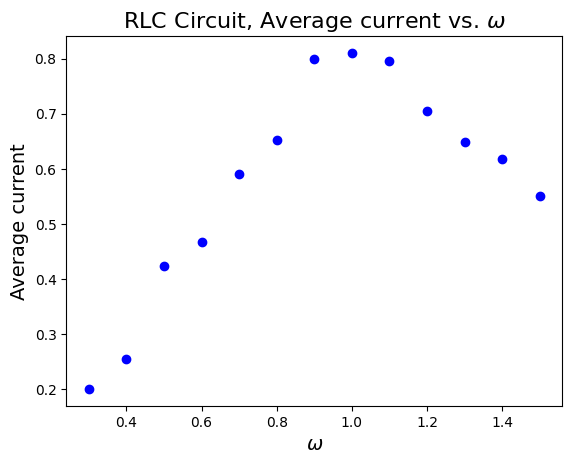

In [16]:
# plot the results

plt.scatter(omega_f_arr, amp_arr, label='$\\dot{q}$', color='blue')
plt.xlabel(r'$\omega$', fontsize=14)
plt.ylabel('Average current', fontsize=14)
plt.title(r'RLC Circuit, Average current vs. $\omega$', fontsize=16)
# plt.savefig('RLC_circuit_average_current.png')
plt.show()